In [ ]:
from IPython.display import Image

## Redes de Neuronas Convolucionales
Resolver mediante redes de neuronas convoluciones el problema de clasificación SIGNS en el cual se pretende predecir el número que se muestra mediante signos con la mano. 



Image(filename="/content/signs.png")


Implementa:
* Un modelo desarrollado desde cero.
* Un modelo que haga uso de transfer learning. Se puede utilizar los modelos de keras u otros modelos/pesos que se obtengan de internet. En ese caso, referenciar.

Identificar el modelo óptimo. Será necesario presentar pruebas que verifiquen la adecuación del modelo elegido.

Explicar de forma detallada cada uno de los pasos realizados para el análisis, preparación y resolución del problema así como el motivo de su aplicación.

#### IMPORTANTE: Modifica el nombre del fichero con tu nombre y apellido

In [ ]:
# Solo en google colab
%tensorflow_version 2.x

###1. Importamos las librerías necesarias

In [ ]:
from tensorflow import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

###2. Cargamos los datos, escalamos las imagenes y realizamos la separación de conjunto de las imagenes para realizar el entrenamiento así como conjunto de imajenes para test y validación: 

In [ ]:
import h5py
import numpy as np

def load_dataset():
    train_dataset = h5py.File('train_signs.h5', "r")
    X_train = np.array(train_dataset["train_set_x"][:])/255
    y_train = np.array(train_dataset["train_set_y"][:])

    test_dataset = h5py.File('test_signs.h5', "r")
    X_test = np.array(test_dataset["test_set_x"][:])/255
    y_test = np.array(test_dataset["test_set_y"][:])

    classes = np.array(test_dataset["list_classes"][:])
    
    return X_train, y_train, X_test, y_test, classes

In [ ]:
X_train, y_train, X_test, y_test, classes = load_dataset()

In [ ]:
y_train

array([5, 0, 2, ..., 2, 4, 5])

###3. Mostramos una imagen aleatoría así como el tamaño de cada una da las variables creadas para el analisis.

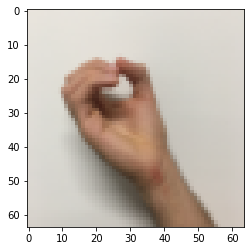

In [ ]:
import matplotlib.pyplot as plt
_ = plt.imshow(X_train[np.random.randint(X_train.shape[0])])

In [ ]:
X_train.shape

(1080, 64, 64, 3)

In [ ]:
y_train.shape

(1080,)

In [ ]:
X_test.shape

(120, 64, 64, 3)

In [ ]:
classes.shape

(6,)

In [ ]:
y_test.shape

(120,)

###4. Realizamos OneHotEnconding de las variables de salida para posteriormente en los modelos creados poder utilizar la función de perdidas categorical_crossentropy

In [ ]:
# OneHotEncoding para AUC
from sklearn.preprocessing import LabelBinarizer

le = LabelBinarizer().fit(classes)
y_train= le.transform(y_train)
y_test= le.transform(y_test)

In [ ]:
y_train

array([[0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       ...,
       [0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1]])

###5. Creamos los filtros primero de 7x7 despues de 3x3 y aplicamos a las imagenes para la detección de bordes

In [ ]:
batch_size, height, width, channels = X_train.shape
# Creamos un filtro vertical y otro horizonatl
filters_line = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32) 
filters_line[:, 3, :, 0] = 1 # vertical line
filters_line[3, :, :, 1] = 1 # horizontal line
print("Filtro (linea) vertical\n", filters_line[:,:,1,0])
print("Filtro (linea) Horizontal\n", filters_line[:,:,1,1])

Filtro (linea) vertical
 [[0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]]
Filtro (linea) Horizontal
 [[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]]


Crear un filtro vertical y otro horizontal de dimensión 3x3 como los vistos en clase

In [ ]:
filters = np.zeros(shape=(3, 3, channels, 2), dtype=np.float32) 
filters[0, :, :, 0] = 1 # horizontal filter
filters[2, :, :, 0] = -1 # horizontal filter

filters[:, 0, :, 1] = 1 # vertical filter
filters[:, 2, :, 1] = -1 # vertical filter
print("Filtro horizontal\n", filters[:,:,1,0])
print("Filtro vertical\n", filters[:,:,1,1])

Filtro horizontal
 [[ 1.  1.  1.]
 [ 0.  0.  0.]
 [-1. -1. -1.]]
Filtro vertical
 [[ 1.  0. -1.]
 [ 1.  0. -1.]
 [ 1.  0. -1.]]


#### Realizamos una convolución con los filtros
Utilizar `tf.nn.conv2d` para aplicar los filtros creados a las imagenes. 
El tamaño de la imagen resultante tiene que ser el mismo que el de las imagenes de entrada.

In [ ]:
print(X_train.shape)
outputs = tf.nn.conv2d(X_train, filters, strides=1, padding="SAME")
print(outputs.shape)

(1080, 64, 64, 3)
(1080, 64, 64, 2)


¿Cuántos canales tienen las imagenes antes y después de aplicar los filtros?

SOLUCION: 3 canales de entrada, 2 de salida

#### Filtro horizontal

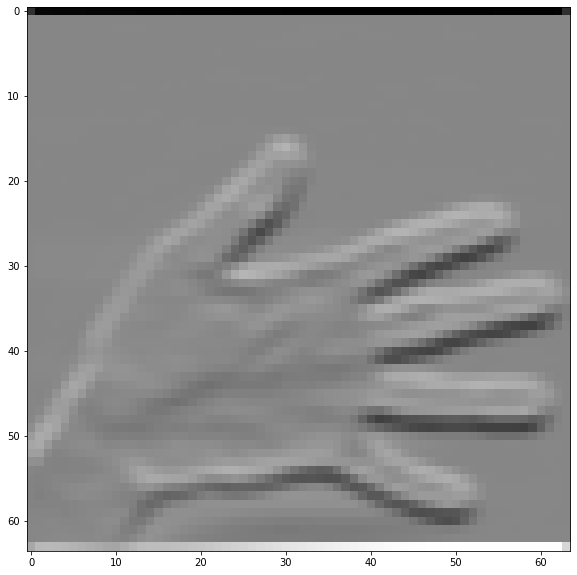

In [ ]:
plt.figure(figsize=(20,10))
_ = plt.imshow(outputs[0, :, :, 0], cmap="gray") #

#### Filtro vertical

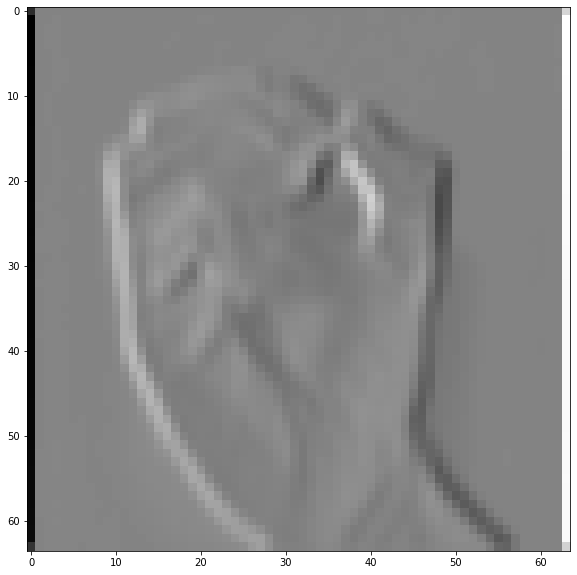

In [ ]:
plt.figure(figsize=(20,10))
_ = plt.imshow(outputs[1, :, :, 1], cmap="gray")

###6. Pooling

#### Max Pooling con $f=3, s=3$ para altura y anchura
El resultado es una imagen de menor resolución con los rasgos más importantes. Se puede ver que los bordes están más diferenciados.

Utilizar `tf.nn.max_pool` para aplicar max pooling espacial (anchura y altura) con un padding válido

Kernel Size y strides esperan una tupla con tamaño/stride  `( entre instancias, altura, anchura, canales)`

In [ ]:
#Sobre la imagen original
#output = tf.nn.max_pool(X_train, ksize=(1, 3, 3, 1), strides=(1, 3, 3, 1), padding="VALID")
#Sobre el resultado de la convolución
output = tf.nn.max_pool(outputs, ksize=(1, 3, 3, 1), strides=(1, 3, 3, 1), padding="VALID")
#Repetir operación para resaltar mas los resultados
#output = tf.nn.max_pool(output, ksize=(1, 3, 3, 1), strides=(1, 3, 3, 1), padding="VALID")

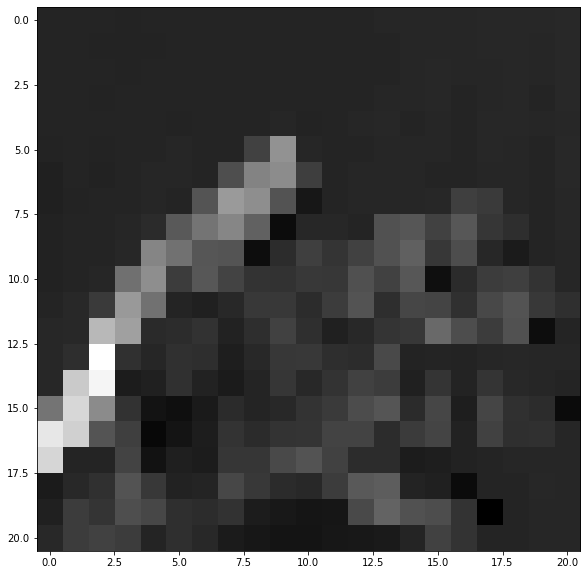

In [ ]:
plt.figure(figsize=(20,10))
_ = plt.imshow(output[0, :, :, 1], cmap="gray")

###7. Max Pooling con $f=2, s=2$ para los canales
El resultado es una imagen en escala de grises. Al utilizar un pool de tipo máximo, de nuevo los rasgos más importantes son realzados.

Si lo aplicamos sobre los resultados de los filtros verticales y horizontales, tendremos una combinación de los bordes resaltados tanto verticales como horizontales.

Utilizar tf.nn.max_pool para aplicar max pooling en profundidad (canales) con un padding válido.

In [ ]:
output = tf.nn.max_pool(outputs, ksize=(1, 1, 1, 2), strides=(1, 1, 1, 2), padding="VALID")

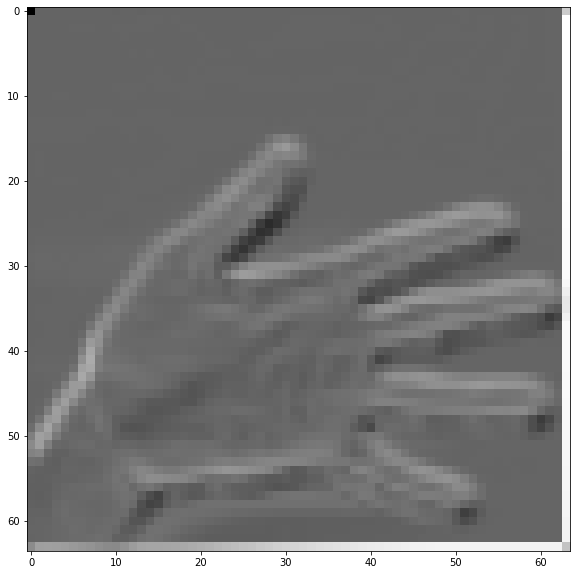

In [ ]:
plt.figure(figsize=(20,10))
_ = plt.imshow(output[0, :, :, 0], cmap="gray")

# Redes de Neuronas Convolucionales realizadas:

# 1.Mi primera CNN: Fashion Mnist
Cambiamos el entorno a GPU.

Partiendo de la CNN realizada en clase realizo la siguiente Red:

### Creo una CNN utilizando padding de tipo samme con:
* 1 capa con 64 filtros de dimensión 7 y max pool de dimensión 2 **(Cambio la entrada)**
* 1 capa con convolucion de 128 filtros de dimensión 3 y max pool de dimensión 2
* 1 capa con convolucion de 256 filtros de dimensión 3 y max pool de dimensión 2
* 1 capa de tipo Dense de dimensión 128
* Dropout a 0.5
* 1 capa de tipo Dense de dimensión 64
* **Dropout a 0.5 (Esta la elimino)**
* 1 capa de tipo de Dense de dimensión 6 **(Cambio la salida)**.

También al haber realizado el OneHOtEncoding de las variables de salida, cambio la función de pedidas **loss=categorical_crossentropy**. 

In [ ]:
model = keras.models.Sequential([

    keras.layers.Conv2D(filters=64, kernel_size=7, activation='relu', input_shape=[64, 64, 3]),

    keras.layers.MaxPool2D(pool_size=2),

    keras.layers.Conv2D(128,3,activation="relu", padding="same"),

    keras.layers.MaxPool2D(pool_size=2),

    keras.layers.Conv2D(256,3,activation="relu", padding="same"),

    keras.layers.MaxPool2D(pool_size=2),

    keras.layers.Flatten(),

    keras.layers.Dense(units=128, activation='relu'),

    keras.layers.Dropout(0.5),

    keras.layers.Dense(units=64, activation='relu'),

    keras.layers.Dense(units=6, activation='softmax'),

])



model.summary()



model.compile(optimizer='nadam',

              loss='categorical_crossentropy',

              metrics=['accuracy']

              )



history = model.fit(X_train,y_train, validation_split = 0.2, epochs=25)

print('CNN básica: ', model.evaluate(X_test, y_test))

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_58 (Conv2D)           (None, 58, 58, 64)        9472      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 29, 29, 64)        0         
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 29, 29, 128)       73856     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_60 (Conv2D)           (None, 14, 14, 256)       295168    
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 7, 7, 256)         0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 12544)            

### Con mi primera CNN alcanzo un accuracy con datos de test de **94,17%** y veo que no ha habido sobreaprendizaje.

###Tras hablar contigo te indiqué que pensaba que si la entrenaba más a lo mejor podría mejorar el resultado para ello tal como me indicaste voy ha hacerlo pero utilizado **EarlyStopping de Keras**

In [ ]:
from keras.callbacks import EarlyStopping
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

model = keras.models.Sequential([

    keras.layers.Conv2D(filters=64, kernel_size=7, activation='relu', input_shape=[64, 64, 3]),

    keras.layers.MaxPool2D(pool_size=2),

    keras.layers.Conv2D(128,3,activation="relu", padding="same"),

    keras.layers.MaxPool2D(pool_size=2),

    keras.layers.Conv2D(256,3,activation="relu", padding="same"),

    keras.layers.MaxPool2D(pool_size=2),

    keras.layers.Flatten(),

    keras.layers.Dense(units=128, activation='relu'),

    keras.layers.Dropout(0.5),

    keras.layers.Dense(units=64, activation='relu'),

    keras.layers.Dense(units=6, activation='softmax'),

])



model.summary()



model.compile(optimizer='nadam',

              loss='categorical_crossentropy',

              metrics=['accuracy']

              )



history = model.fit(X_train,y_train, validation_split = 0.2, epochs=50,callbacks=[callback],verbose=1)

print('CNN básica: ', model.evaluate(X_test, y_test))


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 58, 58, 64)        9472      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 29, 29, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 29, 29, 128)       73856     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 256)       295168    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 7, 7, 256)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 12544)            

###He podido comprobar que aunque lo he entrenado 46 epochs (21 epochs más) no he mejorado el accuracy, mantengo el mismo resultado **94,17%**. Se ha detenido antes de llegar al epoch 50 para evitar sobreaprendizaje.

# 2. ResNet

Parto de la CNN creada en clase y sólo cambio:
  - input_shape: 64,64,3.
  - salida:6.
  - loss:categorical_crossentropy
  
Creamos el Residual Block


In [ ]:
#SOLUCION
class ResidualBlock(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            #Convolución: filters filtros de dimension 3, padding=samme y strides=strides sin bías
            keras.layers.Conv2D(filters, 3, strides=strides, padding="same", use_bias=False),
            #Aplicar batch normalization
            keras.layers.BatchNormalization(), 
            #Aplicamos función de activación
            self.activation, 
            #Convolución: filters filtros de dimension 3, padding=samme y strides=1 sin bías
            keras.layers.Conv2D(filters, 3, strides=1, padding="same", use_bias=False),
            #Aplicar batch normalization
            keras.layers.BatchNormalization()
        ]
        self.skip_layers = [] 
        if strides > 1:
            self.skip_layers = [
                #Convolución: filters filtros de dimension 1, padding=samme y strides=strides sin bías
                keras.layers.Conv2D(filters, 1, strides=strides, padding="same", use_bias=False), 
                #Aplicar batch normalization
                keras.layers.BatchNormalization()
            ]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers: 
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

Ahora creamos el modelo

In [ ]:
model = keras.models.Sequential()
# Convolución 64 filtros de dimension 7, padding=samme y strides=2 sin bías
# Preparar el modelo para trabajar con Fashion Mnist
model.add(keras.layers.Conv2D(64, 7, strides=2, input_shape=[64, 64, 3], padding="same", use_bias=False))
#Original para trabajar con imagenes de Image Net
# model.add(keras.layers.Conv2D(64, 7, strides=2, input_shape=[224, 224, 3], padding="same", use_bias=False))
# Batch Normalization
model.add(keras.layers.BatchNormalization())
#Aplicamos función de activación relu
model.add(keras.layers.Activation("relu"))
# Max pool de dimension 3 con stride 2 y padding same
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same")) 
prev_filters = 64
# Añadimos 3 residual blocks de 64 filtros, 4 de 128, 6 de 265 y 3 de 512
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2 
    model.add(ResidualBlock(filters, strides=strides))
    prev_filters = filters
# Aplicamos GlobalAvgPool2D (Maximo de cada canal)
model.add(keras.layers.GlobalAvgPool2D())
# Convertimos las entradas en un vector para poder pasarlo a una capa Dense
model.add(keras.layers.Flatten())
# Creamos la capa de salida para clasificación con 10 posibles clases mutuamente excluyentes
model.add(keras.layers.Dense(6, activation="softmax"))

Realizo el modelo con Residual Blocks para resolver Fashion Mnist

In [ ]:
model.summary()

model.compile(optimizer='nadam',
              loss='categorical_crossentropy',
              metrics=['accuracy']
              )

history = model.fit(X_train, y_train, validation_split = 0.2, epochs=20)
print('CNN básica: ', model.evaluate(X_test, y_test))

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_61 (Conv2D)           (None, 32, 32, 64)        9408      
_________________________________________________________________
batch_normalization_40 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
residual_block_16 (ResidualB (None, 16, 16, 64)        74240     
_________________________________________________________________
residual_block_17 (ResidualB (None, 16, 16, 64)        74240     
_________________________________________________________________
residual_block_18 (ResidualB (None, 16, 16, 64)       

### Con **Residual Block** alcanzo un accuracy con datos de test de **95%** y veo que no ha habido sobreaprendizaje, por lo que mejoro con respecto a la primera CNN.

###Al igual que en la anterior CNN voy a intentar entrenarla más y para ello voy ha hacerlo pero utilizado **EarlyStopping de Keras**

In [ ]:
class ResidualBlock(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            #Convolución: filters filtros de dimension 3, padding=samme y strides=strides sin bías
            keras.layers.Conv2D(filters, 3, strides=strides, padding="same", use_bias=False),
            #Aplicar batch normalization
            keras.layers.BatchNormalization(), 
            #Aplicamos función de activación
            self.activation, 
            #Convolución: filters filtros de dimension 3, padding=samme y strides=1 sin bías
            keras.layers.Conv2D(filters, 3, strides=1, padding="same", use_bias=False),
            #Aplicar batch normalization
            keras.layers.BatchNormalization()
        ]
        self.skip_layers = [] 
        if strides > 1:
            self.skip_layers = [
                #Convolución: filters filtros de dimension 1, padding=samme y strides=strides sin bías
                keras.layers.Conv2D(filters, 1, strides=strides, padding="same", use_bias=False), 
                #Aplicar batch normalization
                keras.layers.BatchNormalization()
            ]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers: 
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

model = keras.models.Sequential()
# Convolución 64 filtros de dimension 7, padding=samme y strides=2 sin bías
# Preparar el modelo para trabajar con Fashion Mnist
model.add(keras.layers.Conv2D(64, 7, strides=2, input_shape=[64, 64, 3], padding="same", use_bias=False))
#Original para trabajar con imagenes de Image Net
# model.add(keras.layers.Conv2D(64, 7, strides=2, input_shape=[224, 224, 3], padding="same", use_bias=False))
# Batch Normalization
model.add(keras.layers.BatchNormalization())
#Aplicamos función de activación relu
model.add(keras.layers.Activation("relu"))
# Max pool de dimension 3 con stride 2 y padding same
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same")) 
prev_filters = 64
# Añadimos 3 residual blocks de 64 filtros, 4 de 128, 6 de 265 y 3 de 512
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2 
    model.add(ResidualBlock(filters, strides=strides))
    prev_filters = filters
# Aplicamos GlobalAvgPool2D (Maximo de cada canal)
model.add(keras.layers.GlobalAvgPool2D())
# Convertimos las entradas en un vector para poder pasarlo a una capa Dense
model.add(keras.layers.Flatten())
# Creamos la capa de salida para clasificación con 10 posibles clases mutuamente excluyentes
model.add(keras.layers.Dense(6, activation="softmax"))


from keras.callbacks import EarlyStopping
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

model.summary()

model.compile(optimizer='nadam',
              loss='categorical_crossentropy',
              metrics=['accuracy']
              )

history = model.fit(X_train,y_train, validation_split = 0.2, epochs=50,callbacks=[callback],verbose=1)

print('CNN básica: ', model.evaluate(X_test, y_test))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 32, 32, 64)        9408      
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
residual_block (ResidualBloc (None, 16, 16, 64)        74240     
_________________________________________________________________
residual_block_1 (ResidualBl (None, 16, 16, 64)        74240     
_________________________________________________________________
residual_block_2 (ResidualBl (None, 16, 16, 64)       

### Pablo en este caso tengo dudas con el resultado:  porque creo que puede haber sobreaprendizaje si observo el accuracy de train del 100% pero también es cierto que nos indicaste que cuando sucede el sobreaprendizaje pasan cosas raras con los datos de test ( y en este caso no tengo subidas y bajadas bruscas con los datos de test) por lo que para mi no me queda del todo claro este resultado del **98,33%**.
### Tambien si me fijo en el caso anterior de esta red tengo accuracy de train de 100% al final del entrenamiento y me indicaste que no había sobreaprendizaje ya que en los datos de test no había esos cambios bruscos.

# 3. CNN con Transfer Learning - cargamos ResNet

[Keras](https://keras.io/applications/) proporciona modelos de algunas de las redes convolucionales más famosas entrenadas para reconocer imagenes de [Image Net](http://www.image-net.org/)

Esto nos simplifica bastante el entrenamiento cuando tenemos la posibilidad de hacer **transfer learning**.

Cargo directamente una red ResNet 

**En este caso lo hago pero sé de antemano que no voy a obtener un buen resultado ya que el tipo de red seleccionada está entrenada para la detección de objetos y no es la más adecuada para este problema**

In [ ]:
model = keras.applications.resnet50.ResNet50(weights="imagenet")

Intentemos reconocer qué son las imagenes utilizando el modelo cargado.

In [ ]:
images_resized = tf.image.resize(X_train, [224, 224])
inputs = keras.applications.resnet50.preprocess_input(images_resized * 255)
Y_proba = model.predict(inputs)
top_K = keras.applications.resnet50.decode_predictions(Y_proba, top=3) 
for image_index in range(len(X_train)):
    print("Image #{}".format(image_index))
    for class_id, name, y_proba in top_K[image_index]:
        print(" {} - {:12s} {:.2f}%".format(class_id, name, y_proba * 100))
    print()

Se han truncado las últimas 5000 líneas del flujo de salida.
Image #80
 n02786058 - Band_Aid     64.24%
 n04591157 - Windsor_tie  10.92%
 n03970156 - plunger      6.24%

Image #81
 n03970156 - plunger      37.36%
 n03250847 - drumstick    10.69%
 n02786058 - Band_Aid     7.28%

Image #82
 n02786058 - Band_Aid     28.58%
 n04357314 - sunscreen    12.15%
 n03314780 - face_powder  5.28%

Image #83
 n02786058 - Band_Aid     19.85%
 n03250847 - drumstick    11.41%
 n04357314 - sunscreen    8.68%

Image #84
 n02786058 - Band_Aid     46.06%
 n04591157 - Windsor_tie  25.52%
 n04350905 - suit         3.11%

Image #85
 n04372370 - switch       43.26%
 n04591157 - Windsor_tie  12.59%
 n02786058 - Band_Aid     7.15%

Image #86
 n03250847 - drumstick    40.78%
 n03970156 - plunger      19.85%
 n02786058 - Band_Aid     16.49%

Image #87
 n03250847 - drumstick    19.46%
 n04372370 - switch       16.66%
 n04254120 - soap_dispenser 13.62%

Image #88
 n04591157 - Windsor_tie  8.83%
 n02951585 - can_open

### Tal como avanzaba no es la más adecuada para la resolución de este problema y vemos que no acierta nada. 

# 4. CNN con Transfer Learning - cargamos Xception

En este caso realizo los siguientes cambios sobre el código utilizado en clase:
- No utilizo el preprocesado de las imagenes.
- Cambio input  y output con los datos de este ejemplo.
- Cambio la función de perdida: loss a categorical_crossentropy. 
- El entrenamiento lo realizo al igual que en los anteriores modelos sin utilizar el 75% de los datos.

In [ ]:
#SOLUCION
#Importemos modelo base (Xception) sin las capas de clasificación (include_top=False)
base_model = keras.applications.xception.Xception(weights="imagenet", include_top=False)
#Añadimos nuestras capas para hacer clasificación
# Aplicar Global Average Pooling
avg = keras.layers.GlobalAveragePooling2D()(base_model.output) 
# Crear capa de salida para clasificación con n_classes mutuamente excluyentes
output = keras.layers.Dense(6, activation="softmax")(avg) 
#Definimos el modelo
model = keras.Model(inputs=base_model.input, outputs=output)

Preparemos y entrenemos el modelo

In [ ]:
# Congelamos los peso del modelo base para sacar el máximo partido del modelo preentrenado
for layer in base_model.layers: 
    layer.trainable = False
    
#Comencemos con una constante de aprendizaje un poco más agresiva
optimizer = keras.optimizers.SGD(lr=0.2, momentum=0.9, decay=0.01)
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
# Para datasets muy grandes es conveniente definir el número de paso por epoca (steps_per_epoch)
history = model.fit(X_train, y_train, validation_split = 0.2, epochs=20)
print('CNN básica: ', model.evaluate(X_test, y_test))

Epoch 1/20
27/27 [==============================] - 3s 52ms/step - loss: 0.0763 - accuracy: 0.9923 - val_loss: 0.2662 - val_accuracy: 0.9167
Epoch 2/20
27/27 [==============================] - 1s 26ms/step - loss: 0.0617 - accuracy: 0.9933 - val_loss: 0.2700 - val_accuracy: 0.9120
Epoch 3/20
27/27 [==============================] - 1s 26ms/step - loss: 0.0730 - accuracy: 0.9940 - val_loss: 0.2656 - val_accuracy: 0.9167
Epoch 4/20
27/27 [==============================] - 1s 25ms/step - loss: 0.0632 - accuracy: 0.9955 - val_loss: 0.2652 - val_accuracy: 0.9120
Epoch 5/20
27/27 [==============================] - 1s 26ms/step - loss: 0.0676 - accuracy: 0.9934 - val_loss: 0.2642 - val_accuracy: 0.9167
Epoch 6/20
27/27 [==============================] - 1s 26ms/step - loss: 0.0825 - accuracy: 0.9922 - val_loss: 0.2654 - val_accuracy: 0.9120
Epoch 7/20
27/27 [==============================] - 1s 26ms/step - loss: 0.0619 - accuracy: 0.9961 - val_loss: 0.2667 - val_accuracy: 0.9120
Epoch 8/20
27

Lo más normal es que el entrenamiento se quede **atascado** en un nivel de precisión no satisfactorio. Si esto sucede, continuamos el entrenamiento incluyendo los pesos del modelo preentrenado y aplicando una constande de aprendizaje menor.

*  Ya lo hemos aplicado con una constante de parendizaje: $0.01$

Ahora lo hacemos:

* Decaimiento de la constante de aprendizaje $0.001$.

In [ ]:
# Congelamos los peso del modelo base para sacar el máximo partido del modelo preentrenado
for layer in base_model.layers: 
    layer.trainable = False
    
#Comencemos con una constante de aprendizaje un menos agresiva
optimizer = keras.optimizers.SGD(lr=0.2, momentum=0.9, decay=0.001)
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
# Para datasets muy grandes es conveniente definir el número de paso por epoca (steps_per_epoch)
history = model.fit(X_train, y_train, validation_split = 0.2, epochs=20)
print('CNN básica: ', model.evaluate(X_test, y_test))

Epoch 1/20
27/27 [==============================] - 3s 54ms/step - loss: 0.0658 - accuracy: 0.9934 - val_loss: 0.2653 - val_accuracy: 0.9167
Epoch 2/20
27/27 [==============================] - 1s 26ms/step - loss: 0.0583 - accuracy: 0.9949 - val_loss: 0.2623 - val_accuracy: 0.9167
Epoch 3/20
27/27 [==============================] - 1s 26ms/step - loss: 0.0613 - accuracy: 0.9939 - val_loss: 0.2678 - val_accuracy: 0.9120
Epoch 4/20
27/27 [==============================] - 1s 26ms/step - loss: 0.0598 - accuracy: 0.9953 - val_loss: 0.2689 - val_accuracy: 0.9120
Epoch 5/20
27/27 [==============================] - 1s 26ms/step - loss: 0.0562 - accuracy: 0.9964 - val_loss: 0.2665 - val_accuracy: 0.9120
Epoch 6/20
27/27 [==============================] - 1s 26ms/step - loss: 0.0525 - accuracy: 0.9979 - val_loss: 0.2673 - val_accuracy: 0.9120
Epoch 7/20
27/27 [==============================] - 1s 26ms/step - loss: 0.0496 - accuracy: 0.9989 - val_loss: 0.2668 - val_accuracy: 0.9074
Epoch 8/20
27

### El accuracy obtenido en los datos de test y aplicando el decamiento de la constante de aprendizaje a 0,001 es de **92,50%**

### Como me indicaste que este caso habías obtenido un 96%, intento mejorarlo para ello pienso lo siguiente: 
- Teniendo en cuenta que es una transfer Learning he de centrarme en las capas  que añado de salida. La red que mejor resultado me ha dado es la RestNet (Punto 2) por lo que veo cuales han sido las últimas capas de salida, tenemos la Global Average Poling pero antes de la Dense de salida también usamos una Flatten, por lo que la incorporo en el modelo: "flatten=keras.layers.Flatten()(avg)".
- Introduzco también EarlyStopping de Keras y aumento el entrenamiento a 50 epochs.
- Utilizo la constante de aprendizaje menor de 0,001.
- Cambio el learning rate a 0.1.

In [ ]:
#SOLUCION
#Importemos modelo base (Xception) sin las capas de clasificación (include_top=False)
base_model = keras.applications.xception.Xception(weights="imagenet", include_top=False)
#Añadimos nuestras capas para hacer clasificación
# Aplicar Global Average Pooling
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
#Convertimos las entradas en un vector para poder pasarlo a una capa Dense
flatten=keras.layers.Flatten()(avg)
# Crear capa de salida para clasificación con n_classes mutuamente excluyentes
output = keras.layers.Dense(6, activation="softmax")(flatten) 
#Definimos el modelo
model = keras.Model(inputs=base_model.input, outputs=output)


# Congelamos los peso del modelo base para sacar el máximo partido del modelo preentrenado
for layer in base_model.layers: 
    layer.trainable = False

#Importo EarlyStopping
from keras.callbacks import EarlyStopping
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
    
#Comencemos con una constante de aprendizaje menos agresiva
optimizer = keras.optimizers.SGD(lr=0.1, momentum=0.9, decay=0.001)
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
# Para datasets muy grandes es conveniente definir el número de paso por epoca (steps_per_epoch)
history = model.fit(X_train,y_train, validation_split = 0.2, epochs=50,callbacks=[callback],verbose=1)
print('CNN básica: ', model.evaluate(X_test, y_test))

83689472/83683744 [==============================] - 2s 0us/step
Epoch 1/50
27/27 [==============================] - 33s 57ms/step - loss: 1.3586 - accuracy: 0.4700 - val_loss: 0.6825 - val_accuracy: 0.7870
Epoch 2/50
27/27 [==============================] - 0s 19ms/step - loss: 0.6608 - accuracy: 0.7848 - val_loss: 0.6315 - val_accuracy: 0.7639
Epoch 3/50
27/27 [==============================] - 0s 19ms/step - loss: 0.4701 - accuracy: 0.8684 - val_loss: 0.5977 - val_accuracy: 0.8472
Epoch 4/50
27/27 [==============================] - 0s 19ms/step - loss: 0.4107 - accuracy: 0.8773 - val_loss: 0.4033 - val_accuracy: 0.8843
Epoch 5/50
27/27 [==============================] - 0s 19ms/step - loss: 0.3817 - accuracy: 0.8906 - val_loss: 0.3632 - val_accuracy: 0.9028
Epoch 6/50
27/27 [==============================] - 0s 19ms/step - loss: 0.2907 - accuracy: 0.9232 - val_loss: 0.3867 - val_accuracy: 0.8889
Epoch 7/50
27/27 [==============================] - 0s 19ms/step - loss: 0.2677 - accura

###Consigo subir un poco el accuracy a **93,33%**

#5. Realizo un último intento de una CNN propia para ver si mejoro el resultado.

  - 1 capa con 64 filtros de dimensión 3 y max pool de dimensión 2.
  - 1 capa con convolucion de 128 filtros de dimensión 3 y max pool de dimensión 2.
  - 1 capa con convolucion de 256 filtros de dimensión 3 y max pool de dimensión 2.
  - 1 capa LeakyRelu con alpha=0.1 y max pool de dimensión 2.
  - Dropout a 0.5
  - Flatten
  - 1 capa de tipo Dense de dimensión 128
  - Dropout a 0.5
  - 1 capa de tipo Dense de dimensión 64
  - 1 capa LeakyRelu con alpha=0.1
  - Dropout a 0.5
  - 1 capa de tipo de Dense de dimensión 6
  - La función de activación es 'relu' a excepción de la salida 'softmax'(también he probado con kernel_initializer='lecun_normal',activation='selu' y da el mismo resultado), también he hecho pruebas cambiando la función de activación.
  - Aplico también EarlyStopping de Keras y entreno todo lo que puedo.
  - He probado con todos los tipos de optimizers y el que mejor funciona es: **optimizers.Adamax(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name="Adamax")**

In [ ]:
#Importo EarlyStopping
from keras.callbacks import EarlyStopping
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

epochs=1000

 
mano_model = keras.models.Sequential()
mano_model.add(keras.layers.Conv2D(64, kernel_size=(3, 3),activation='relu',padding='same',input_shape=(64,64,3)))
mano_model.add(keras.layers.MaxPool2D(pool_size=2))
mano_model.add(keras.layers.Conv2D(128,3, activation='relu', padding="same")) 
mano_model.add(keras.layers.MaxPool2D(pool_size=2))
mano_model.add(keras.layers.Conv2D(256,3, activation='relu', padding="same"))
mano_model.add(keras.layers.MaxPool2D(pool_size=2))
mano_model.add(keras.layers.LeakyReLU(alpha=0.1))
mano_model.add(keras.layers.MaxPooling2D((2, 2),padding='same'))
mano_model.add(keras.layers.Dropout(0.5))
mano_model.add(keras.layers.Flatten())
mano_model.add(keras.layers.Dense(units=128, activation='relu'))
mano_model.add(keras.layers.Dropout(0.5))
mano_model.add(keras.layers.Dense(64,activation='relu'))
mano_model.add(keras.layers.LeakyReLU(alpha=0.1))
mano_model.add(keras.layers.Dropout(0.5)) 
mano_model.add(keras.layers.Dense(6, activation='softmax'))
 
mano_model.summary()
 


optimizer = keras.optimizers.Adamax(
    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name="Adamax")
mano_model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

history = mano_model.fit(X_train,y_train, validation_split = 0.2, epochs=epochs,callbacks=[callback],verbose=1)
print('CNN básica: ', mano_model.evaluate(X_test, y_test))

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 64, 64, 64)        1792      
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 32, 32, 128)       73856     
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 16, 16, 256)       295168    
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 8, 8, 256)         0         
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 8, 8, 256)        

## Finalmente obtengo con una CNN propia un accuracy de 96,67%



---



###Otros intentos para realizar la última CNN propia presentada en el punto 5.

In [ ]:
#Importo EarlyStopping
from keras.callbacks import EarlyStopping
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

epochs=1000

 
mano_model = keras.models.Sequential()
mano_model.add(keras.layers.Conv2D(64, kernel_size=(3, 3),kernel_initializer='lecun_normal',activation='selu',padding='same',input_shape=(64,64,3)))
mano_model.add(keras.layers.MaxPool2D(pool_size=2))
mano_model.add(keras.layers.Conv2D(128,3, kernel_initializer='lecun_normal',activation='selu', padding="same")) 
mano_model.add(keras.layers.MaxPool2D(pool_size=2))
mano_model.add(keras.layers.Conv2D(256,3,kernel_initializer='lecun_normal',activation='selu', padding="same"))
mano_model.add(keras.layers.MaxPool2D(pool_size=2))
mano_model.add(keras.layers.LeakyReLU(alpha=0.1))
mano_model.add(keras.layers.MaxPooling2D((2, 2),padding='same'))
mano_model.add(keras.layers.Dropout(0.5))
mano_model.add(keras.layers.Flatten())
mano_model.add(keras.layers.Dense(units=128, kernel_initializer='lecun_normal',activation='selu'))
mano_model.add(keras.layers.Dropout(0.5))
mano_model.add(keras.layers.Dense(64, kernel_initializer='lecun_normal',activation='selu'))
mano_model.add(keras.layers.LeakyReLU(alpha=0.1))
mano_model.add(keras.layers.Dropout(0.5)) 
mano_model.add(keras.layers.Dense(6, activation='softmax'))
 
mano_model.summary()
 


optimizer = keras.optimizers.Adamax(
    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name="Adamax")
mano_model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

history = mano_model.fit(X_train,y_train, validation_split = 0.2, epochs=epochs,callbacks=[callback],verbose=1)
print('CNN básica: ', mano_model.evaluate(X_test, y_test))

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 64, 64, 64)        1792      
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 32, 32, 128)       73856     
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 16, 16, 256)       295168    
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 8, 8, 256)         0         
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 8, 8, 256)        

In [ ]:
#Importo EarlyStopping
from keras.callbacks import EarlyStopping
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

epochs=1000

 
mano_model = keras.models.Sequential()
mano_model.add(keras.layers.Conv2D(64, kernel_size=(3, 3),kernel_initializer='lecun_normal',activation='selu',padding='same',input_shape=(64,64,3)))
mano_model.add(keras.layers.MaxPool2D(pool_size=2))
mano_model.add(keras.layers.Conv2D(128,3, kernel_initializer='lecun_normal',activation='selu', padding="same")) 
mano_model.add(keras.layers.MaxPool2D(pool_size=2))
mano_model.add(keras.layers.Conv2D(256,3,kernel_initializer='lecun_normal',activation='selu', padding="same"))
mano_model.add(keras.layers.MaxPool2D(pool_size=2))
mano_model.add(keras.layers.LeakyReLU(alpha=0.1))
mano_model.add(keras.layers.MaxPooling2D((2, 2),padding='same'))
mano_model.add(keras.layers.Dropout(0.5))
mano_model.add(keras.layers.Flatten())
mano_model.add(keras.layers.Dense(units=128, kernel_initializer='lecun_normal',activation='selu'))
mano_model.add(keras.layers.Dropout(0.5))
mano_model.add(keras.layers.Dense(64, kernel_initializer='lecun_normal',activation='selu'))
mano_model.add(keras.layers.LeakyReLU(alpha=0.1))
mano_model.add(keras.layers.Dropout(0.5)) 
mano_model.add(keras.layers.Dense(6, activation='softmax'))
 
mano_model.summary()
 

#Comencemos con una constante de aprendizaje menos agresiva


optimizer = keras.optimizers.Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    name="Adam")
mano_model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
# Para datasets muy grandes es conveniente definir el número de paso por epoca (steps_per_epoch)
history = mano_model.fit(X_train,y_train, validation_split = 0.2, epochs=epochs,callbacks=[callback],verbose=1)
print('CNN básica: ', mano_model.evaluate(X_test, y_test))

Model: "sequential_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_112 (Conv2D)          (None, 64, 64, 64)        1792      
_________________________________________________________________
max_pooling2d_124 (MaxPoolin (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_113 (Conv2D)          (None, 32, 32, 128)       73856     
_________________________________________________________________
max_pooling2d_125 (MaxPoolin (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_114 (Conv2D)          (None, 16, 16, 256)       295168    
_________________________________________________________________
max_pooling2d_126 (MaxPoolin (None, 8, 8, 256)         0         
_________________________________________________________________
leaky_re_lu_84 (LeakyReLU)   (None, 8, 8, 256)       

In [ ]:
#Importo EarlyStopping
from keras.callbacks import EarlyStopping
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

epochs=1000

 
mano_model = keras.models.Sequential()
mano_model.add(keras.layers.Conv2D(64, kernel_size=(3, 3),activation='relu',padding='same',input_shape=(64,64,3)))
mano_model.add(keras.layers.MaxPool2D(pool_size=2))
mano_model.add(keras.layers.Conv2D(128,3, activation='relu', padding="same")) 
mano_model.add(keras.layers.MaxPool2D(pool_size=2))
mano_model.add(keras.layers.Conv2D(256,3, activation='relu', padding="same"))
mano_model.add(keras.layers.MaxPool2D(pool_size=2))
mano_model.add(keras.layers.LeakyReLU(alpha=0.1))
mano_model.add(keras.layers.MaxPooling2D((2, 2),padding='same'))
mano_model.add(keras.layers.Dropout(0.5))
mano_model.add(keras.layers.Flatten())
mano_model.add(keras.layers.Dense(units=128, activation='relu'))
mano_model.add(keras.layers.Dropout(0.5))
mano_model.add(keras.layers.Dense(64,activation='relu'))
mano_model.add(keras.layers.LeakyReLU(alpha=0.1))
mano_model.add(keras.layers.Dropout(0.5)) 
mano_model.add(keras.layers.Dense(6, activation='softmax'))
 
mano_model.summary()
 

#Comencemos con una constante de aprendizaje menos agresiva


optimizer = keras.optimizers.Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    name="Adam")
mano_model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
# Para datasets muy grandes es conveniente definir el número de paso por epoca (steps_per_epoch)
history = mano_model.fit(X_train,y_train, validation_split = 0.2, epochs=epochs,callbacks=[callback],verbose=1)
print('CNN básica: ', mano_model.evaluate(X_test, y_test))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 64, 64, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 16, 256)       295168    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 256)         0         
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 8, 8, 256)         0

In [ ]:
#Importo EarlyStopping
from keras.callbacks import EarlyStopping
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

epochs=1000

 
mano_model = keras.models.Sequential()
mano_model.add(keras.layers.Conv2D(64, kernel_size=(3, 3),activation='relu',padding='same',input_shape=(64,64,3)))
mano_model.add(keras.layers.MaxPool2D(pool_size=2))
mano_model.add(keras.layers.Conv2D(128,3, activation='relu', padding="same")) 
mano_model.add(keras.layers.MaxPool2D(pool_size=2))
mano_model.add(keras.layers.Conv2D(256,3, activation='relu', padding="same"))
mano_model.add(keras.layers.MaxPool2D(pool_size=2))
mano_model.add(keras.layers.LeakyReLU(alpha=0.1))
mano_model.add(keras.layers.MaxPooling2D((2, 2),padding='same'))
mano_model.add(keras.layers.Dropout(0.5))
mano_model.add(keras.layers.Flatten())
mano_model.add(keras.layers.Dense(units=128, activation='relu'))
mano_model.add(keras.layers.Dropout(0.5))
mano_model.add(keras.layers.Dense(64,activation='relu'))
mano_model.add(keras.layers.LeakyReLU(alpha=0.1))
mano_model.add(keras.layers.Dropout(0.5)) 
mano_model.add(keras.layers.Dense(6, activation='softmax'))
 
mano_model.summary()
 

#Comencemos con una constante de aprendizaje menos agresiva


optimizer = keras.optimizers.Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    name="Adam")
mano_model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
# Para datasets muy grandes es conveniente definir el número de paso por epoca (steps_per_epoch)
history = mano_model.fit(X_train,y_train, validation_split = 0.2, epochs=epochs,callbacks=[callback],verbose=1)
print('CNN básica: ', mano_model.evaluate(X_test, y_test))

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 64, 64, 64)        1792      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 32, 32, 128)       73856     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 16, 16, 256)       295168    
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 8, 8, 256)         0         
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 8, 8, 256)        

In [ ]:
#Importo EarlyStopping
from keras.callbacks import EarlyStopping
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)


INIT_LR = 1e-3
epochs = 1000
 
mano_model = keras.models.Sequential()
mano_model.add(keras.layers.Conv2D(64, kernel_size=(3, 3),activation='linear',padding='same',input_shape=(64,64,3)))
mano_model.add(keras.layers.MaxPool2D(pool_size=2))
mano_model.add(keras.layers.Conv2D(128,3,activation="linear", padding="same")) 
mano_model.add(keras.layers.MaxPool2D(pool_size=2))
mano_model.add(keras.layers.Conv2D(256,3,activation="linear", padding="same"))
mano_model.add(keras.layers.MaxPool2D(pool_size=2))
mano_model.add(keras.layers.LeakyReLU(alpha=0.1))
##mano_model.add(keras.layers.MaxPooling2D((2, 2),padding='same'))
##mano_model.add(keras.layers.Dropout(0.5))
mano_model.add(keras.layers.Flatten())
mano_model.add(keras.layers.Dense(units=128, activation='linear'))
mano_model.add(keras.layers.Dropout(0.5))
mano_model.add(keras.layers.Dense(64, activation='linear'))
mano_model.add(keras.layers.LeakyReLU(alpha=0.1))
mano_model.add(keras.layers.Dropout(0.5)) 
mano_model.add(keras.layers.Dense(6, activation='softmax'))
 
mano_model.summary()
 
mano_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adagrad(lr=INIT_LR, decay=INIT_LR / 100),metrics=['accuracy'])

history = mano_model.fit(X_train,y_train, validation_split = 0.2, epochs=epochs,callbacks=[callback],verbose=1)
print('CNN básica: ', mano_model.evaluate(X_test, y_test))

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_67 (Conv2D)           (None, 64, 64, 64)        1792      
_________________________________________________________________
max_pooling2d_71 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_68 (Conv2D)           (None, 32, 32, 128)       73856     
_________________________________________________________________
max_pooling2d_72 (MaxPooling (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_69 (Conv2D)           (None, 16, 16, 256)       295168    
_________________________________________________________________
max_pooling2d_73 (MaxPooling (None, 8, 8, 256)         0         
_________________________________________________________________
leaky_re_lu_54 (LeakyReLU)   (None, 8, 8, 256)       

In [ ]:
#Importo EarlyStopping
from keras.callbacks import EarlyStopping
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)


INIT_LR = 1e-3
epochs = 1000
 
mano_model = keras.models.Sequential()
mano_model.add(keras.layers.Conv2D(64, kernel_size=(5, 5),activation='elu',padding='same',input_shape=(64,64,3)))
mano_model.add(keras.layers.MaxPool2D(pool_size=2))
mano_model.add(keras.layers.Conv2D(128,3,activation="elu", padding="same")) 
mano_model.add(keras.layers.MaxPool2D(pool_size=2))
mano_model.add(keras.layers.Conv2D(256,3,activation="elu", padding="same"))
mano_model.add(keras.layers.MaxPool2D(pool_size=2))
mano_model.add(keras.layers.LeakyReLU(alpha=0.1))
#mano_model.add(keras.layers.MaxPooling2D((2, 2),padding='same'))
#mano_model.add(keras.layers.Dropout(0.5))
mano_model.add(keras.layers.Flatten())
mano_model.add(keras.layers.Dense(units=128, activation='elu'))
mano_model.add(keras.layers.Dropout(0.5))
mano_model.add(keras.layers.Dense(64, activation='elu'))
mano_model.add(keras.layers.LeakyReLU(alpha=0.1))
mano_model.add(keras.layers.Dropout(0.5)) 
mano_model.add(keras.layers.Dense(6, activation='softmax'))
 
mano_model.summary()
 
mano_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adagrad(lr=INIT_LR, decay=INIT_LR / 100),metrics=['accuracy'])

history = mano_model.fit(X_train,y_train, validation_split = 0.2, epochs=epochs,callbacks=[callback],verbose=1)
print('CNN básica: ', mano_model.evaluate(X_test, y_test))

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_55 (Conv2D)           (None, 64, 64, 64)        4864      
_________________________________________________________________
max_pooling2d_59 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 32, 32, 128)       73856     
_________________________________________________________________
max_pooling2d_60 (MaxPooling (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 16, 16, 256)       295168    
_________________________________________________________________
max_pooling2d_61 (MaxPooling (None, 8, 8, 256)         0         
_________________________________________________________________
leaky_re_lu_46 (LeakyReLU)   (None, 8, 8, 256)       